In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [3]:
import glob
import itertools
import os
import sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [4]:
sys.path.append("../../..")

In [5]:
from bertrand.model.tokenization import AA_list
from bertrand.negative_decoys.basic_filtering import (
    basic_filtering as basic_filtering_bertrand,
)
from bertrand.negative_decoys.basic_filtering import (
    read_positives_and_group_by_tcr,
    read_reference_tcrs,
)

In [6]:
from bertrand.immrep.data_sources import read_be, read_test, read_train_immrep, read_train_vdjdb

In [12]:
diagnostics(test)

3484 examples
0 usable examples, 3484 in limbo
### CDR
Length disribution
    CDR3a_extended  CDR3b_extended
7                2               0
8                6               0
9               10              25
10              54               9
11             305              58
12             570             213
13             647             813
14             796             739
15             622             675
16             275             544
17             145             260
18              36              75
19               8              45
20               5               7
21               1              19
24               2               0
22               0               2
637 CDR3a unique in 3484
632 CDR3b unique in 3484
727 unique CDR3a,CDR3b pairs in 3484
### Peptide
20 unique peptides
0.51 observations in top 5 peptides
0.75 observations in top 10 peptides
0.89 observations in top 15 peptides
Test set peptides present
Observations for test peptides
True    20


In [13]:
train_immrep3 = pd.read_csv("../../../data/immrep/VDJdb_paired_chain.csv")

In [14]:
diagnostics(train_immrep3)

11312 examples
10035 usable examples, 1277 in limbo
### CDR
Length disribution
    CDR3a_extended  CDR3b_extended
5                4               0
6                4               0
7               13               1
8               20               3
9               65               8
10             440              54
11            1145             297
12            1828             777
13            2261            2866
14            2036            2357
15            1872            2324
16             806            1379
17             523             740
18             177             291
19              64             146
20              24              51
21              23              11
22               3               2
23               1               3
24               1               0
25               0               2
8651 CDR3a unique in 11312
8993 CDR3b unique in 11312
11140 unique CDR3a,CDR3b pairs in 11312
### Peptide
808 unique peptides
0.44 observations in top 

In [15]:
be = pd.read_parquet("../../../data/binding-estimation")

In [16]:
be.shape

(5170369, 43)

In [17]:
binders = be[be.is_binder]

In [18]:
pd.crosstab(binders.CDR3_alpha.isna(), binders.CDR3_beta.isna())

CDR3_beta,False,True
CDR3_alpha,,
False,28559,7297
True,38533,2


In [19]:
alpha_beta_binders = binders[~binders.CDR3_beta.isna() & ~binders.CDR3_alpha.isna()]

In [20]:
alpha_beta_binders.reference_id.value_counts().head(20)

https://www.jimmunol.org/content/202/1_Supplement/131.4              13644
10x CMV                                                               2737
PMID:34793243                                                         1816
PMID:30479382                                                          963
PMID:34341799|https://github.com/antigenomics/vdjdb-db/issues/326      764
PMID:28636592                                                          754
ardigen_healthy/donor_12                                               693
ardigen_healthy/donor_6                                                648
PMID:35750048                                                          641
ardigen_healthy/donor_8                                                492
ardigen_healthy/donor_10                                               452
ardigen_healthy/donor_4                                                434
PMID:28103239                                                          296
ardigen_healthy/donor_9  

In [21]:
alpha_beta_binders.shape

(28559, 43)

In [22]:
train_immuno = alpha_beta_binders.rename(
    columns={"CDR3_alpha": "CDR3a_extended", "CDR3_beta": "CDR3b_extended", "HLA": "HLA_pseudoseq", "HLA_type": "HLA"}
)

In [23]:
train_immuno_wo_10x = train_immuno[train_immuno.reference_id != train_immuno.reference_id.value_counts().index[0]]

In [24]:
diagnostics(train_immuno)

28559 examples
26944 usable examples, 1615 in limbo
### CDR
Length disribution
    CDR3a_extended  CDR3b_extended
8               95               6
9              147              16
10             984             115
11            2637             886
12            4590            2124
13            5570            5926
14            5435            5869
15            4610            6444
16            2361            3759
17            1389            1924
18             451             853
19             200             429
20              55             121
21              20              60
22              12              21
23               1               5
25               2               0
24               0               1
17042 CDR3a unique in 28559
18279 CDR3b unique in 28559
20496 unique CDR3a,CDR3b pairs in 28559
### Peptide
1057 unique peptides
0.50 observations in top 5 peptides
0.63 observations in top 10 peptides
0.70 observations in top 15 peptides
Test set peptides

In [25]:
diagnostics(train_immuno_wo_10x)

14915 examples
14038 usable examples, 877 in limbo
### CDR
Length disribution
    CDR3a_extended  CDR3b_extended
8               41               4
9               97              13
10             678              64
11            1626             458
12            2479            1153
13            2749            3152
14            2772            3196
15            2359            3326
16            1221            1921
17             554             945
18             211             388
19              94             192
20              18              67
21               6              29
22               9               5
23               1               2
10114 CDR3a unique in 14915
10783 CDR3b unique in 14915
11580 unique CDR3a,CDR3b pairs in 14915
### Peptide
1042 unique peptides
0.29 observations in top 5 peptides
0.43 observations in top 10 peptides
0.55 observations in top 15 peptides
Test set peptides present
Observations for test peptides
False     6
True     14
Name: P

In [26]:
import glob

df_list = []
for fn in glob.glob("../../../data/immrep22/true_set/*.txt"):
    peptide = os.path.splitext(os.path.basename(fn))[0]

    print(peptide)
    df = pd.read_csv(fn, sep="\t")
    if "Global" in peptide:
        df = df.rename(columns={"Epitope_GroundTruth": "Peptide"})
        # continue
    else:
        df["Peptide"] = peptide
    df["HLA"] = ""
    df = df.rename(columns={"TRB_CDR3": "CDR3b_extended", "TRA_CDR3": "CDR3a_extended"})
    df_list.append(df)


train_immrep22 = pd.concat(df_list).reset_index(drop=True)
diagnostics(train_immrep22)

GILGFVFTL
LTDEMIAQY
YLQPRTFLL
NLVPMVATV
NYNYLYRLF
KSKRTPMGF
SPRWYFYYL
RAQAPPPSW
GLCTLVAML
testSet_Global
LLWNGPMAV
GPRLGVRAT
HPVTKYIM
TTDPSFLGRY
CINGVCWTV
ATDALMTGF
TPRVTGGGAM
NQKLIANQF
4294 examples
3886 usable examples, 408 in limbo
### CDR
Length disribution
    CDR3a_extended  CDR3b_extended
6                2               0
7                6               2
8               11               1
9               26               0
10             206               9
11             555             123
12             739             311
13             725            1119
14             791             887
15             662             852
16             315             551
17             178             264
18              60             113
19              15              34
20               2              23
21               1               5
2661 CDR3a unique in 4294
2729 CDR3b unique in 4294
2946 unique CDR3a,CDR3b pairs in 4294
### Peptide
17 unique peptides
0.60 observations in t

In [27]:
# import glob

# df_list = []
# for fn in glob.glob("../../../../vdjdb-db/chunks/*.txt"):

#     df = pd.read_csv(fn, sep="\t")
#     raise Exception()
#     # df['HLA'] = ''
#     df = df.rename(columns={"TRB_CDR3": "CDR3b_extended", "TRA_CDR3": "CDR3a_extended"})
#     df_list.append(df)


# train_immrep22 = pd.concat(df_list).reset_index(drop=True)
# diagnostics(train_immrep22)

In [28]:
train_vdjdb = pd.read_csv("../../../data/vdjdb/vdjdb_full.txt", sep="\t")

/tmp/ipykernel_6774/1700424722.py:1: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  train_vdjdb = pd.read_csv("../../../data/vdjdb/vdjdb_full.txt", sep="\t")


In [29]:
train_vdjdb = train_vdjdb.rename(
    columns={
        "cdr3.alpha": "CDR3a_extended",
        "cdr3.beta": "CDR3b_extended",
        "mhc.a": "HLA",
        "antigen.epitope": "Peptide",
    }
)

In [30]:
train_vdjdb.iloc[0]

CDR3a_extended                                               CIVRAPGRADMRF
v.alpha                                                        TRAV26-1*01
j.alpha                                                          TRAJ43*01
CDR3b_extended                                        CASSYLPGQGDHYSNQPQHF
v.beta                                                           TRBV13*01
d.beta                                                                 NaN
j.beta                                                          TRBJ1-5*01
species                                                        HomoSapiens
HLA                                                               HLA-B*08
mhc.b                                                                  B2M
mhc.class                                                             MHCI
Peptide                                                           FLKEKGGL
antigen.gene                                                           Nef
antigen.species          

In [31]:
train_vdjdb = train_vdjdb[
    ~train_vdjdb.CDR3a_extended.isna()
    & ~train_vdjdb.CDR3b_extended.isna()
    & (train_vdjdb.species == "HomoSapiens")
    & (train_vdjdb["mhc.class"] == "MHCI")
]

In [32]:
diagnostics(train_vdjdb)

27571 examples
25760 usable examples, 1811 in limbo
### CDR
Length disribution
    CDR3a_extended  CDR3b_extended
5                1               0
6                4               0
7                8               0
8               80               9
9              136              17
10             836             127
11            2437             796
12            4519            1969
13            5395            5683
14            5208            5575
15            4530            6248
16            2273            3633
17            1453            2015
18             447             885
19             173             382
20              38             150
21              15              52
22               9              17
23               2               7
24               3               1
25               3               2
26               1               3
19862 CDR3a unique in 27571
21232 CDR3b unique in 27571
25074 unique CDR3a,CDR3b pairs in 27571
### Peptide
830 uniq

In [33]:
# my_data = pd.read_csv("../../../data/phla_tcr_all.csv.gz")

# my_data[~my_data.CDR3a.isna() & ~my_data.CDR3b.isna()].shape

In [34]:
def get_test_counts(train):
    return train.Peptide[train.Peptide.isin(test.Peptide)].value_counts()  # .fillna(0).astype(int)

In [35]:
stats = (
    pd.concat(
        [
            get_test_counts(train)
            for train in [train_immrep3, train_immuno, train_immuno_wo_10x, train_immrep22, train_vdjdb]
        ],
        axis=1,
    )
    .fillna(0)
    .astype(int)
)

In [36]:
stats.columns = ["immrep3", "immuno", "immuno wo 10x", "immrep22", "vdjdb"]

In [37]:
stats

,immrep3,immuno,immuno wo 10x,immrep22,vdjdb
GILGFVFTL,1818,2217,1296,948,2194
RAKFKQLL,1066,985,258,0,1235
YLQPRTFLL,434,397,397,466,472
NLVPMVATV,390,714,713,480,588
GLCTLVAML,351,661,590,257,394
IVTDFSVIK,332,856,8,0,729
TPRVTGGGAM,62,377,376,81,63
RPPIFIRRL,45,341,340,0,36
RPHERNGFTVL,27,294,293,0,29
EPLPQGQLTAY,14,9,9,0,15


## Test set sampling

In [38]:
l = test.CDR3a_extended.str.len()
CDRA_MIN, CDRA_MAX = l.min(), l.max()
l = test.CDR3b_extended.str.len()
CDRB_MIN, CDRB_MAX = l.min(), l.max()
(CDRA_MIN, CDRA_MAX), (CDRB_MIN, CDRB_MAX)

((7, 24), (9, 22))

In [39]:
from Levenshtein import distance
from scipy.spatial.distance import cdist
from tqdm.auto import tqdm

In [40]:
def dist(x, y):
    return distance(x[0], y[0])

In [41]:
def sample_test(train, test, Tpos=70, Tneg=120, filter_lev=True, seed=42):
    # train = train_vdjdb
    np.random.seed(seed)
    pos = train[["Peptide", "CDR3b_extended", "CDR3a_extended"]].drop_duplicates()
    pos = pos[pos.Peptide.isin(test.Peptide)]
    vc = pos["Peptide"].value_counts()
    peps = vc.index[vc >= 10]
    pos = pos[pos.Peptide.isin(peps)]
    pos["y"] = 1

    # pos.shape
    # Tpos = 70
    # Tneg = 120

    # potential_tcr_negatives = pos.groupby("Peptide").apply(lambda x: x.sample(frac=fracneg) if len(x) >= 10/fracneg else x).reset_index(drop=True)
    potential_tcr_negatives = (
        pos.groupby("Peptide")
        .apply(lambda x: x.sample(Tneg, replace=False) if len(x) >= Tneg else x)
        .reset_index(drop=True)
    )

    peps = pd.Series(peps, index=peps)
    rlist = []

    for i, pep in enumerate(peps.index):
        print(pep)
        pep_positives = pos[pos.Peptide == pep].copy()
        pos_i = pd.MultiIndex.from_frame(pep_positives[cdrcols])

        dist_over_3 = peps.apply(lambda p: distance(p, pep) > 3)
        pep_potential_negatives = peps[dist_over_3]

        train_neg = potential_tcr_negatives[potential_tcr_negatives.Peptide.isin(pep_potential_negatives)]
        train_neg = train_neg[cdrcols].drop_duplicates()
        train_neg_i = pd.MultiIndex.from_frame(train_neg)
        train_neg = train_neg[~train_neg_i.isin(pos_i)]

        if filter_lev:
            adist = cdist(
                train_neg.CDR3a_extended.values.reshape(-1, 1),
                pep_positives.CDR3a_extended.values.reshape(-1, 1),
                metric=dist,
            )
            bdist = cdist(
                train_neg.CDR3b_extended.values.reshape(-1, 1),
                pep_positives.CDR3b_extended.values.reshape(-1, 1),
                metric=dist,
            )
            adist, bdist = adist.min(axis=1), bdist.min(axis=1)
            # print(adist)
            # print(adist.shape)
            print(train_neg.shape[0])
            train_neg = train_neg[(adist >= 3) & (bdist >= 3)]
            print(train_neg.shape[0])

        # if len(pep_positives) * frac > 10:
        #     pep_positives = pep_positives.sample(frac=frac, replace=False)
        if len(pep_positives) > Tpos:
            pep_positives = pep_positives.sample(Tpos, replace=False)

        sample_neg = train_neg.sample(min(len(pep_positives) * 5, len(train_neg)), replace=False)
        sample_neg["Peptide"] = pep
        sample_neg["y"] = 0
        # print(pep, len(pep_positives), len(sample_neg))

        rlist.append(pd.concat([pep_positives, sample_neg]))
    df = pd.concat(rlist)
    df = df.groupby(["Peptide"] + cdrcols).y.agg(max).reset_index()
    m = df.groupby(["CDR3a_extended", "CDR3b_extended", "Peptide"]).y.agg("nunique").unique()
    assert set(m) == {1}
    return df

In [42]:
def sample_test(train, test, frac=0.05, fracneg=0.1, filter_lev=True, seed=42):
    # train = train_vdjdb
    np.random.seed(seed)
    pos = train[["Peptide", "CDR3b_extended", "CDR3a_extended"]].drop_duplicates()
    pos = pos[pos.Peptide.isin(test.Peptide)]
    vc = pos["Peptide"].value_counts()
    peps = vc.index[vc >= 10]
    pos = pos[pos.Peptide.isin(peps)]
    pos["y"] = 1

    la = pos.CDR3a_extended.str.len()
    lb = pos.CDR3b_extended.str.len()
    pos = pos[
        (la >= CDRA_MIN)
        & (la <= CDRA_MAX)
        & (lb >= CDRB_MIN)
        & (lb <= CDRB_MAX)
        & (pos.CDR3a_extended.str[0] == "C")
        & (pos.CDR3b_extended.str[0] == "C")
    ]

    # pos.shape
    # Tpos = 70
    # Tneg = 120

    potential_tcr_negatives = (
        pos.groupby("Peptide")
        .apply(lambda x: x.sample(frac=fracneg) if len(x) >= 10 / fracneg else x)
        .reset_index(drop=True)
    )
    # potential_tcr_negatives = pos.groupby("Peptide").apply(lambda x: x.sample(frac=fracneg)).reset_index(drop=True)

    # potential_tcr_negatives = pos.groupby("Peptide").apply(lambda x: x.sample(Tneg, replace=False) if len(x) >= Tneg else x).reset_index(drop=True)

    peps = pd.Series(peps, index=peps)
    rlist = []

    for i, pep in enumerate(peps.index):
        print(pep)
        pep_positives = pos[pos.Peptide == pep].copy()
        pos_i = pd.MultiIndex.from_frame(pep_positives[cdrcols])

        dist_over_3 = peps.apply(lambda p: distance(p, pep) > 3)
        pep_potential_negatives = peps[dist_over_3]

        train_neg = potential_tcr_negatives[potential_tcr_negatives.Peptide.isin(pep_potential_negatives)]
        train_neg = train_neg[cdrcols].drop_duplicates()
        train_neg_i = pd.MultiIndex.from_frame(train_neg)
        train_neg = train_neg[~train_neg_i.isin(pos_i)]

        if filter_lev:
            adist = cdist(
                train_neg.CDR3a_extended.values.reshape(-1, 1),
                pep_positives.CDR3a_extended.values.reshape(-1, 1),
                metric=dist,
            )
            bdist = cdist(
                train_neg.CDR3b_extended.values.reshape(-1, 1),
                pep_positives.CDR3b_extended.values.reshape(-1, 1),
                metric=dist,
            )
            adist, bdist = adist.min(axis=1), bdist.min(axis=1)
            # print(adist)
            # print(adist.shape)
            print(train_neg.shape[0])
            train_neg = train_neg[(adist >= 3) & (bdist >= 3)]
            print(train_neg.shape[0])

        if len(pep_positives) * frac > 10:
            print(pep, len(pep_positives), frac)
            pep_positives = pep_positives.sample(frac=frac, replace=False)
        # if len(pep_positives) > 70:
        #     pep_positives = pep_positives.sample(70)

        # if len(pep_positives) > Tpos:
        #     pep_positives = pep_positives.sample(Tpos, replace=False)

        print(pep, len(pep_positives), len(train_neg))
        sample_neg = train_neg.sample(min(len(pep_positives) * 5, len(train_neg)), replace=False)
        sample_neg["Peptide"] = pep
        sample_neg["y"] = 0
        # print(pep, len(pep_positives), len(sample_neg))

        rlist.append(pd.concat([pep_positives, sample_neg]))
    df = pd.concat(rlist)
    df = df.groupby(["Peptide"] + cdrcols).y.agg(max).reset_index()
    m = df.groupby(["CDR3a_extended", "CDR3b_extended", "Peptide"]).y.agg("nunique").unique()
    assert set(m) == {1}
    return df

In [43]:
# synthetic_test = sample_test(train_immuno, test, frac=0.05, fracneg=0.16)
synthetic_test = sample_test(
    train_vdjdb,
    test,
    frac=0.05,
    fracneg=0.16,
)

GILGFVFTL
643
231
GILGFVFTL 1899 0.05
GILGFVFTL 95 231
RAKFKQLL
758
248
RAKFKQLL 1212 0.05
RAKFKQLL 61 248
IVTDFSVIK
838
286
IVTDFSVIK 718 0.05
IVTDFSVIK 36 286
YLQPRTFLL
893
544
YLQPRTFLL 441 0.05
YLQPRTFLL 22 544
NLVPMVATV
898
506
NLVPMVATV 413 0.05
NLVPMVATV 21 506
GLCTLVAML
904
529
GLCTLVAML 364 0.05
GLCTLVAML 18 529
TPRVTGGGAM
904
870
TPRVTGGGAM 60 870
RPPIFIRRL
928
898
RPPIFIRRL 36 898
RPHERNGFTVL
935
911
RPHERNGFTVL 29 911
EPLPQGQLTAY
950
929
EPLPQGQLTAY 14 929
YVLDHLIVV
953
939
YVLDHLIVV 11 939
IPSINVHHY
954
948
IPSINVHHY 10 948


In [44]:
# synthetic_test = sample_test(train_immuno, test, Tpos=40, Tneg=120)
# # synthetic_test = negatives(train_vdjdb, test, frac=0.04, fracneg=0.09)

## Basic comparison

In [45]:
vc = train_vdjdb.Peptide.value_counts()
tt = test[test.Peptide.isin(vc[vc >= 10].index)]

In [46]:
tt.shape

(2322, 17)

In [47]:
synthetic_test.shape

(2177, 4)

In [48]:
synthetic_test.y.value_counts()

0    1764
1     413
Name: y, dtype: int64

In [49]:
synthetic_test.groupby(cdrcols).y.max().value_counts()

0    609
1    413
Name: y, dtype: int64

In [50]:
train_vdjdb.Peptide.value_counts().loc["TPRVTGGGAM"]

63

In [51]:
m = synthetic_test.groupby(["CDR3a_extended", "CDR3b_extended", "Peptide"]).y.agg("nunique").unique()
assert set(m) == {1}

In [52]:
synthetic_test.Peptide.value_counts()

TPRVTGGGAM     360
GILGFVFTL      326
RAKFKQLL       309
IVTDFSVIK      216
RPPIFIRRL      216
RPHERNGFTVL    174
YLQPRTFLL      132
NLVPMVATV      126
GLCTLVAML      108
EPLPQGQLTAY     84
YVLDHLIVV       66
IPSINVHHY       60
Name: Peptide, dtype: int64

In [53]:
tt.Peptide.value_counts()

GILGFVFTL      526
RAKFKQLL       362
EPLPQGQLTAY    288
NLVPMVATV      258
YVLDHLIVV      204
GLCTLVAML      144
RPHERNGFTVL    114
IPSINVHHY       96
RPPIFIRRL       90
IVTDFSVIK       84
TPRVTGGGAM      78
YLQPRTFLL       78
Name: Peptide, dtype: int64

In [54]:
tt.shape, synthetic_test.shape

((2322, 17), (2177, 4))

<AxesSubplot:xlabel='CDR3a_extended,CDR3b_extended'>

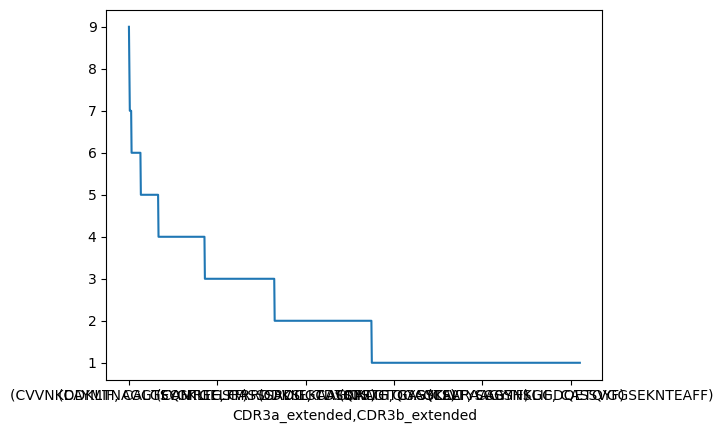

In [55]:
synthetic_test[["CDR3a_extended", "CDR3b_extended"]].value_counts().plot()

<AxesSubplot:>

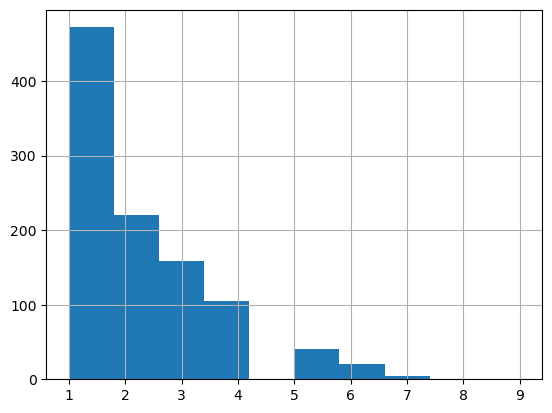

In [56]:
synthetic_test[["CDR3a_extended", "CDR3b_extended"]].value_counts().hist()

In [57]:
vc = train_vdjdb.Peptide.value_counts()
tt = test[test.Peptide.isin(vc[vc >= 10].index)]

<AxesSubplot:>

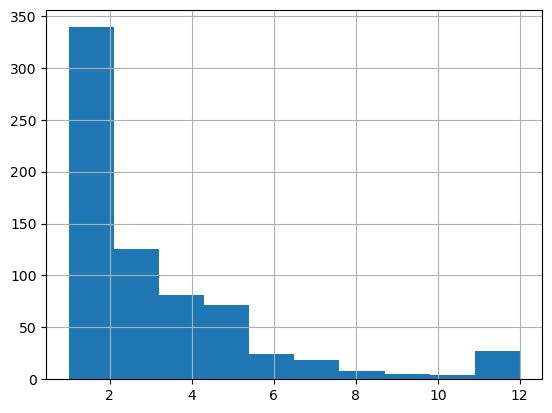

In [58]:
tt[["CDR3a_extended", "CDR3b_extended"]].value_counts().hist()

<AxesSubplot:xlabel='CDR3a_extended,CDR3b_extended'>

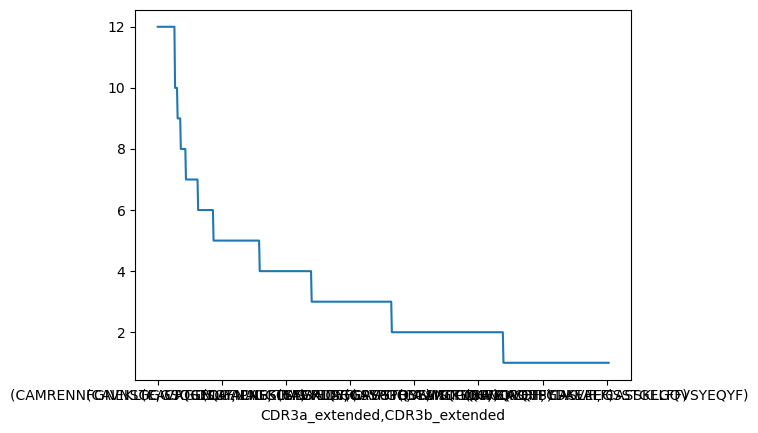

In [59]:
tt[["CDR3a_extended", "CDR3b_extended"]].value_counts().plot()

## Peptide vs repetitions

In [60]:
tt = test[test.Peptide.isin(train_vdjdb.Peptide)]

In [61]:
def get_counts(tt):
    vc = tt[cdrcols].value_counts().reset_index().rename(columns={0: "count"})

    peplist = []
    for c, sdf in vc.groupby("count"):
        pep = tt.set_index(cdrcols).Peptide.loc[pd.MultiIndex.from_frame(sdf)]
        pep.name = str(c)
        peplist.append(pep.value_counts())

    counts = pd.concat(peplist, axis=1).fillna(0).astype(int)

    return counts

In [62]:
tt.Peptide.value_counts()

GILGFVFTL      526
RAKFKQLL       362
EPLPQGQLTAY    288
NLVPMVATV      258
YVLDHLIVV      204
VTEHDTLLY      150
GLCTLVAML      144
RPHERNGFTVL    114
IPSINVHHY       96
QIKVRVDMV       96
RPPIFIRRL       90
IVTDFSVIK       84
TPRVTGGGAM      78
YLQPRTFLL       78
Name: Peptide, dtype: int64

In [63]:
get_counts(tt).loc[tt.Peptide.value_counts().index]

,1,2,3,4,5,6,7,8,9,10,11,12,14
GILGFVFTL,93,119,81,72,58,26,19,15,4,4,5,3,27
RAKFKQLL,28,81,59,54,47,16,19,13,6,4,5,3,27
EPLPQGQLTAY,9,32,52,58,47,15,16,14,6,4,5,3,27
NLVPMVATV,7,16,39,56,47,17,15,15,6,4,6,3,27
YVLDHLIVV,6,12,36,18,41,16,16,14,6,4,5,3,27
VTEHDTLLY,2,6,20,23,14,16,14,10,6,4,5,3,27
GLCTLVAML,3,13,18,9,17,14,15,11,4,4,6,3,27
RPHERNGFTVL,1,11,13,11,12,9,3,12,3,4,5,3,27
IPSINVHHY,1,6,8,11,10,9,3,7,4,3,4,3,27
QIKVRVDMV,0,5,8,10,10,11,4,7,4,3,4,3,27


In [64]:
get_counts(synthetic_test).loc[synthetic_test.Peptide.value_counts().index]

,1,2,3,4,5,6,7,8,9
TPRVTGGGAM,90,89,72,61,27,15,4,1,1
GILGFVFTL,98,45,62,63,33,19,4,1,1
RAKFKQLL,58,46,79,64,36,20,4,1,1
IVTDFSVIK,30,35,54,51,23,19,2,1,1
RPPIFIRRL,37,60,50,37,16,12,2,1,1
RPHERNGFTVL,36,41,41,25,18,10,3,0,0
YLQPRTFLL,27,30,25,27,13,8,0,1,1
NLVPMVATV,32,20,26,28,8,8,2,1,1
GLCTLVAML,29,24,17,19,11,5,2,0,1
EPLPQGQLTAY,17,23,18,12,7,4,2,0,1


In [65]:
# synthetic_test = pep_sample_negatives2(train_vdjdb, test)

In [66]:
pp = np.intersect1d(tt.Peptide, synthetic_test.Peptide)

In [67]:
pp = synthetic_test.Peptide.value_counts().index

In [68]:
pd.concat([synthetic_test.Peptide.value_counts()[pp], tt.Peptide.value_counts()[pp]], axis=1)

,Peptide,Peptide
TPRVTGGGAM,360,78
GILGFVFTL,326,526
RAKFKQLL,309,362
IVTDFSVIK,216,84
RPPIFIRRL,216,90
RPHERNGFTVL,174,114
YLQPRTFLL,132,78
NLVPMVATV,126,258
GLCTLVAML,108,144
EPLPQGQLTAY,84,288


In [69]:
synthetic_test.Peptide.value_counts().shape

(12,)

In [70]:
synthetic_test[synthetic_test.y == 1].Peptide.value_counts()

GILGFVFTL      95
RAKFKQLL       61
TPRVTGGGAM     60
IVTDFSVIK      36
RPPIFIRRL      36
RPHERNGFTVL    29
YLQPRTFLL      22
NLVPMVATV      21
GLCTLVAML      18
EPLPQGQLTAY    14
YVLDHLIVV      11
IPSINVHHY      10
Name: Peptide, dtype: int64

## Exit time analysis

In [71]:
from collections import defaultdict


def exit_time_analysis(tt):
    vc = tt[cdrcols].value_counts()

    p_old = None
    pep_counts = defaultdict(set)
    for (cdra, cdrb), v in vc.iteritems():
        p_current = tt.query(f'CDR3a_extended == "{cdra}" and CDR3b_extended == "{cdrb}"').Peptide.unique()
        for p in p_current:
            pep_counts[p].add(v)
        if p_old is not None:
            missing = np.setdiff1d(p_old, p_current)
            new = np.setdiff1d(p_current, p_old)
            print(len(p_old), len(p_current), missing, new, v)
            # if len(diff) > 0:
            #     print(diff)

        p_old = p_current
    return pep_counts

In [72]:
r = exit_time_analysis(tt)

14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 14 [] [] 14
14 12 ['TPRVTGGGAM' 'YLQPRTFLL'] [] 12
12 12 [] [] 12
12 12 [] [] 12
12 11 ['RPPIFIRRL'] [] 11
11 11 ['IVTDFSVIK'] ['RPPIFIRRL'] 11
11 11 [] [] 11
11 11 [] [] 11
11 9 ['IPSINVHHY' 'QIKVRVDMV'] [] 11
9 10 ['RPPIFIRRL'] ['IPSINVHHY' 'QIKVRVDMV'] 10
10 10 [] [] 10
10 10 [] [] 10
10 10 ['IPSINVHHY' 'QIKVRVDMV'] ['TPRVTGGGAM' 'YLQPRTFLL'] 10
10 9 ['RPHERNGFTVL' 'TPRVTGGGAM' 'YLQPRTFLL'] ['IPSINVHHY' 'QIKVRVDMV'] 9
9 9 ['GLCTLVAML'] ['IVTDFSVIK'] 9
9 9 ['IPSINVHHY' 'QIKVRVDMV'] ['GLCTLVAML' 'RPHERNGFTVL'] 9
9 9 ['GLCTLVAML' 'IVTDFSVIK'] ['IPSINVHHY' 'QIKVRVDMV'] 9
9 9 ['GILGFVFTL' 'IPSINVHHY' 'QIKVRVDMV' 'RPH

In [73]:
r

defaultdict(set,
            {'RAKFKQLL': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14},
             'RPHERNGFTVL': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14},
             'EPLPQGQLTAY': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14},
             'NLVPMVATV': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14},
             'IVTDFSVIK': {1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14},
             'QIKVRVDMV': {2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14},
             'IPSINVHHY': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14},
             'GILGFVFTL': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14},
             'YVLDHLIVV': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14},
             'YLQPRTFLL': {2, 3, 4, 5, 6, 7, 8, 9, 10, 14},
             'TPRVTGGGAM': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14},
             'GLCTLVAML': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14},
             'RPPIFIRRL': {1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 14},
             'VTEHDTLLY': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14}})

In [74]:
r2 = exit_time_analysis(synthetic_test)

9 8 ['EPLPQGQLTAY' 'GLCTLVAML'] ['YVLDHLIVV'] 8
8 7 ['IVTDFSVIK' 'RPPIFIRRL' 'YLQPRTFLL' 'YVLDHLIVV'] ['EPLPQGQLTAY' 'GLCTLVAML' 'RPHERNGFTVL'] 7
7 7 ['NLVPMVATV' 'RPHERNGFTVL'] ['RPPIFIRRL' 'YVLDHLIVV'] 7
7 7 ['EPLPQGQLTAY' 'GLCTLVAML' 'RPPIFIRRL' 'YVLDHLIVV'] ['IPSINVHHY' 'IVTDFSVIK' 'NLVPMVATV' 'RPHERNGFTVL'] 7
7 7 ['IPSINVHHY' 'NLVPMVATV'] ['RPPIFIRRL' 'YVLDHLIVV'] 7
7 6 ['IVTDFSVIK' 'YVLDHLIVV'] ['IPSINVHHY'] 6
6 6 ['GILGFVFTL' 'IPSINVHHY' 'RPPIFIRRL'] ['GLCTLVAML' 'IVTDFSVIK' 'YLQPRTFLL'] 6
6 6 ['GLCTLVAML' 'RAKFKQLL' 'RPHERNGFTVL' 'YLQPRTFLL'] ['GILGFVFTL' 'NLVPMVATV' 'RPPIFIRRL' 'YVLDHLIVV'] 6
6 6 ['NLVPMVATV' 'TPRVTGGGAM' 'YVLDHLIVV'] ['EPLPQGQLTAY' 'RAKFKQLL' 'RPHERNGFTVL'] 6
6 6 ['EPLPQGQLTAY' 'IVTDFSVIK' 'RPHERNGFTVL'] ['IPSINVHHY' 'TPRVTGGGAM' 'YLQPRTFLL'] 6
6 6 ['IPSINVHHY' 'RPPIFIRRL' 'TPRVTGGGAM' 'YLQPRTFLL'] ['EPLPQGQLTAY' 'GLCTLVAML' 'IVTDFSVIK' 'RPHERNGFTVL'] 6
6 6 ['EPLPQGQLTAY' 'GLCTLVAML' 'RPHERNGFTVL'] ['NLVPMVATV' 'TPRVTGGGAM' 'YLQPRTFLL'] 6
6 6 ['NLVPMVATV'] ['

In [75]:
r2

defaultdict(set,
            {'EPLPQGQLTAY': {1, 2, 3, 4, 5, 6, 7, 9},
             'GILGFVFTL': {1, 2, 3, 4, 5, 6, 7, 8, 9},
             'GLCTLVAML': {1, 2, 3, 4, 5, 6, 7, 9},
             'IVTDFSVIK': {1, 2, 3, 4, 5, 6, 7, 8, 9},
             'NLVPMVATV': {1, 2, 3, 4, 5, 6, 7, 8, 9},
             'RAKFKQLL': {1, 2, 3, 4, 5, 6, 7, 8, 9},
             'RPPIFIRRL': {1, 2, 3, 4, 5, 6, 7, 8, 9},
             'TPRVTGGGAM': {1, 2, 3, 4, 5, 6, 7, 8, 9},
             'YLQPRTFLL': {1, 2, 3, 4, 5, 6, 8, 9},
             'YVLDHLIVV': {1, 2, 3, 4, 5, 6, 7, 8},
             'RPHERNGFTVL': {1, 2, 3, 4, 5, 6, 7},
             'IPSINVHHY': {1, 2, 3, 4, 5, 6, 7}})

## Length distribution plots

In [76]:
def plot_length(train, test, col):
    N = 10
    fig, axs = plt.subplots(nrows=N // 5, ncols=5)
    axs = axs.flat
    peps = train[train.Peptide.isin(test.Peptide)].Peptide.value_counts().index
    for i, p in enumerate(peps[:N]):
        ax = axs[i]
        t = test[test.Peptide == p]
        t[col].str.len().hist(ax=ax, density=True, alpha=0.7, label=f"{col} test", bins=np.arange(9, 22))
        # t.CDR3b_extended.str.len().hist(ax=ax, alpha=0.7, label='beta test')

        tr = train[train.Peptide == p]
        tr[col].str.len().hist(ax=ax, density=True, alpha=0.7, label=f"{col} train", bins=np.arange(9, 22))
        # tr.CDR3b_extended.str.len().hist(ax=ax, alpha=0.7, label='beta train')
        if i == 0:
            ax.legend()
        ax.set_title(f"{p} {len(t)} {len(tr)}")

    fig.set_size_inches(16, 9)

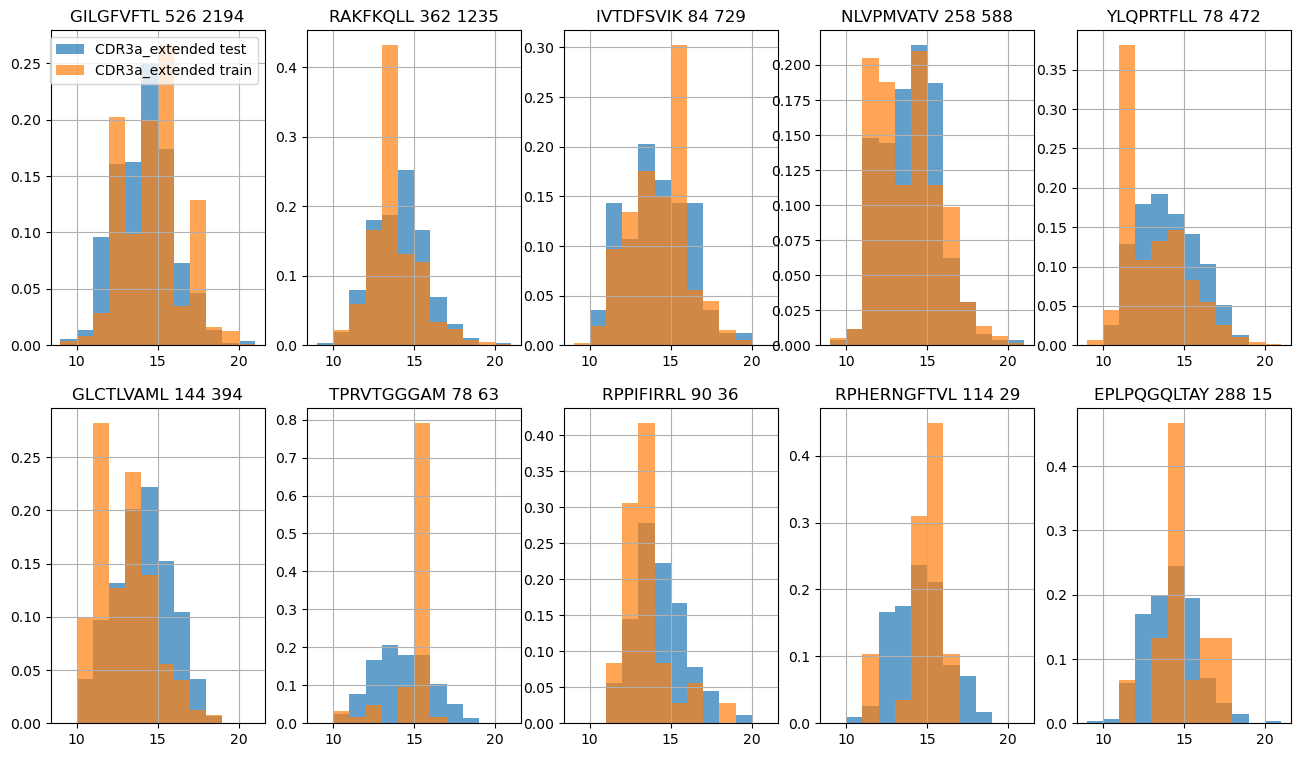

In [77]:
plot_length(train_vdjdb, test, "CDR3a_extended")

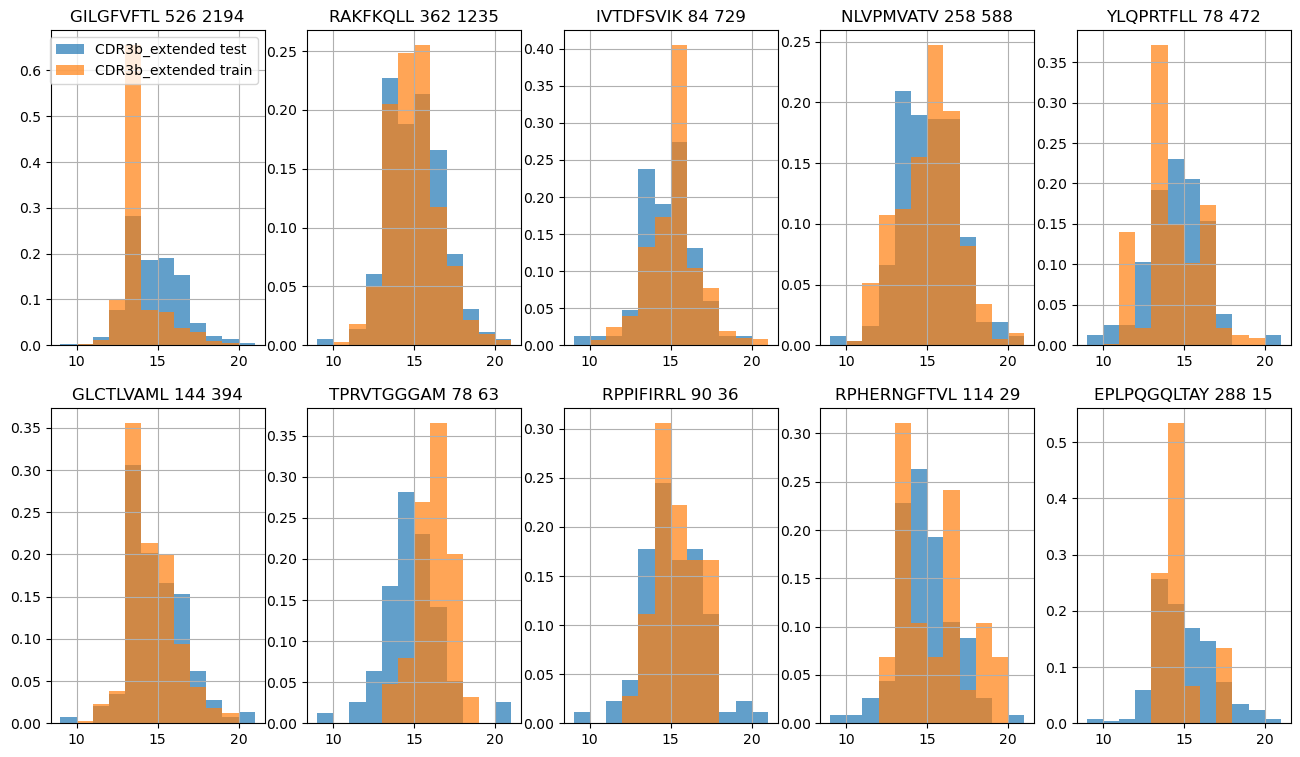

In [78]:
plot_length(train_vdjdb, test, "CDR3b_extended")

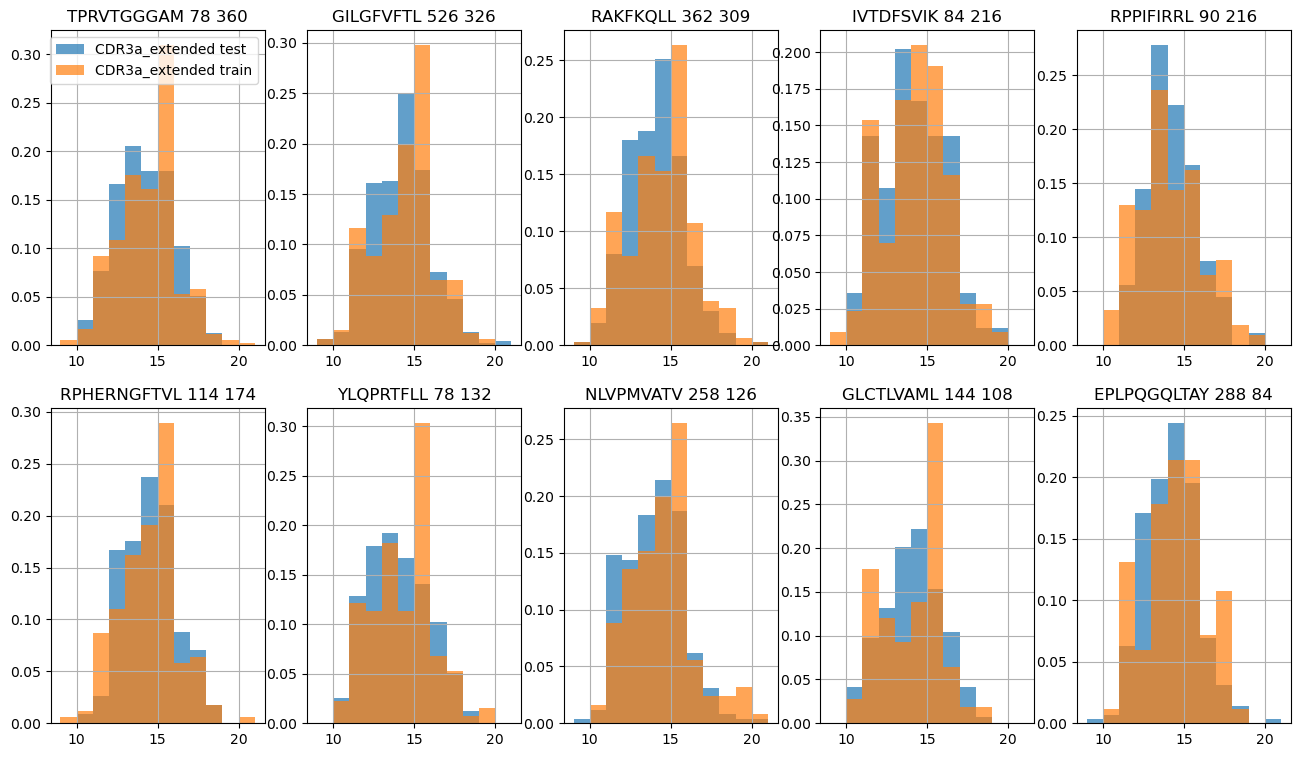

In [79]:
plot_length(synthetic_test, test, "CDR3a_extended")

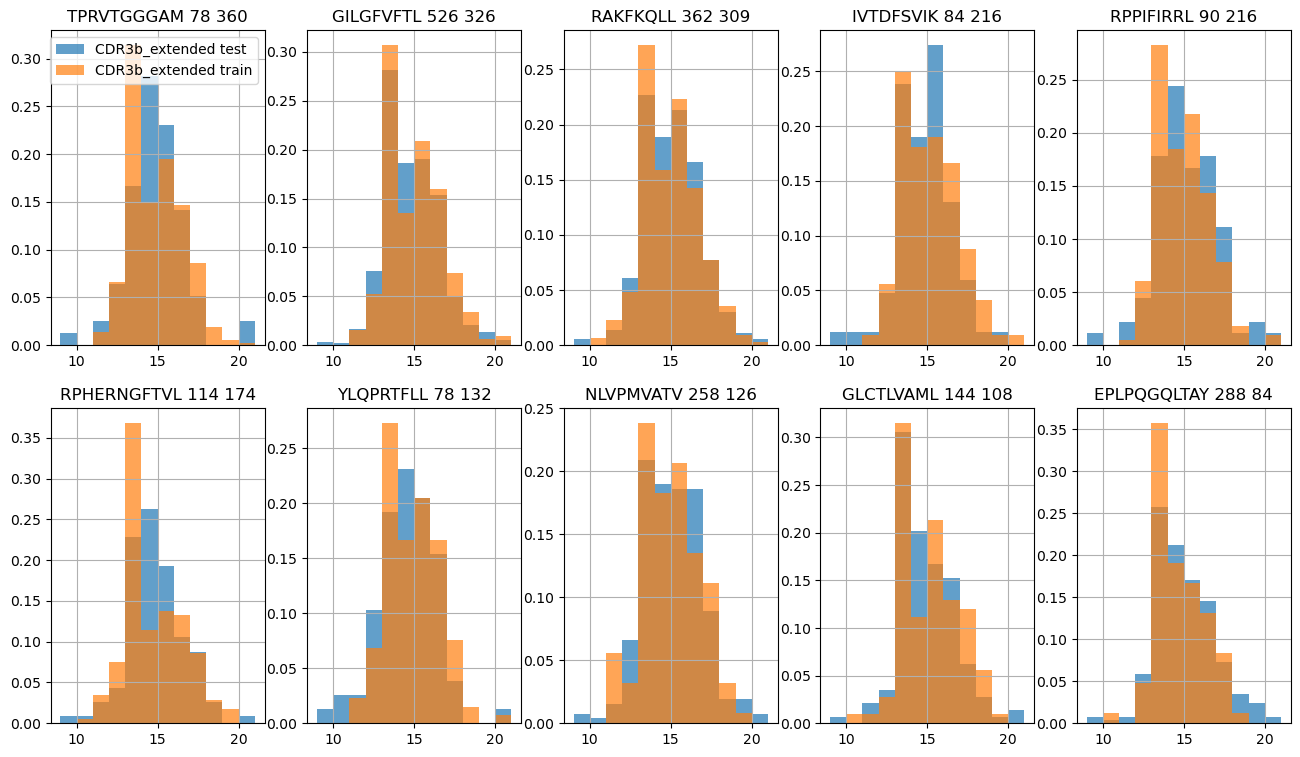

In [80]:
plot_length(synthetic_test, test, "CDR3b_extended")

In [81]:
synthetic_test = sample_test(train_vdjdb, test, frac=0.05, fracneg=0.14)

GILGFVFTL
585
212
GILGFVFTL 1899 0.05
GILGFVFTL 95 212
RAKFKQLL
685
223
RAKFKQLL 1212 0.05
RAKFKQLL 61 223
IVTDFSVIK
753
260
IVTDFSVIK 718 0.05
IVTDFSVIK 36 260
YLQPRTFLL
802
488
YLQPRTFLL 441 0.05
YLQPRTFLL 22 488
NLVPMVATV
806
447
NLVPMVATV 413 0.05
NLVPMVATV 21 447
GLCTLVAML
811
469
GLCTLVAML 364 0.05
GLCTLVAML 18 469
TPRVTGGGAM
804
772
TPRVTGGGAM 60 772
RPPIFIRRL
828
802
RPPIFIRRL 36 802
RPHERNGFTVL
835
812
RPHERNGFTVL 29 812
EPLPQGQLTAY
850
833
EPLPQGQLTAY 14 833
YVLDHLIVV
853
841
YVLDHLIVV 11 841
IPSINVHHY
854
848
IPSINVHHY 10 848


In [82]:
from sklearn.metrics import roc_auc_score

In [83]:
roc_auc_score(synthetic_test.y, synthetic_test.CDR3a_extended.str.len())

0.4918048595078552

In [84]:
roc_auc_score(synthetic_test.y, synthetic_test.CDR3b_extended.str.len())

0.5086420969649191

In [85]:
train = train_vdjdb

In [86]:
def filter_cdr(pos, synthetic_test, t=2):
    adist = cdist(
        pos.CDR3a_extended.values.reshape(-1, 1), synthetic_test.CDR3a_extended.values.reshape(-1, 1), metric=dist
    )
    bdist = cdist(
        pos.CDR3b_extended.values.reshape(-1, 1), synthetic_test.CDR3b_extended.values.reshape(-1, 1), metric=dist
    )

    adist, bdist = adist.min(axis=1), bdist.min(axis=1)

    # (adist >= 2).sum()
    # (bdist >= 2).sum()
    # ((adist >= 2) & (bdist >= 2)).sum()
    return pos[(adist >= t) & (bdist >= t)]

In [7]:
def sample_train(train, test, synthetic_test, T=50):
    pos = train[["Peptide", "CDR3b_extended", "CDR3a_extended"]].drop_duplicates()
    pos["y"] = 1

    assert set([pos.groupby(["Peptide", "CDR3b_extended", "CDR3a_extended"]).y.agg("count").max()]) == {1}

    pos = pos[pos.Peptide.isin(test.Peptide) | pos.Peptide.isin(pos.Peptide.value_counts().iloc[1:].head(10).index)]
    vc = pos["Peptide"].value_counts()
    peps = vc.index[vc >= T]
    pos = pos[pos.Peptide.isin(peps)]

    la = pos.CDR3a_extended.str.len()
    lb = pos.CDR3b_extended.str.len()
    pos = pos[
        (la >= CDRA_MIN)
        & (la <= CDRA_MAX)
        & (lb >= CDRB_MIN)
        & (lb <= CDRB_MAX)
        & (pos.CDR3a_extended.str[0] == "C")
        & (pos.CDR3b_extended.str[0] == "C")
    ]

    print(f"{len(pos)} positive observations total")

    pos_filt = filter_cdr(pos, synthetic_test)
    print(f"{len(pos_filt)} positive observations filtered")
    print(pos_filt.Peptide.value_counts())

    rlist = []
    ppeps = []
    for pep in pos_filt.Peptide.value_counts().index:
        
        pos_pep = pos_filt[pos_filt.Peptide == pep]
        if pep not in test.Peptide.unique() or len(pos_pep) < T:
            continue

        potential_negs = pos_filt[pos_filt.Peptide != pep]
        potential_negs_filt = filter_cdr(potential_negs, pos_pep, t=2).copy()
        print(pep, len(potential_negs), len(potential_negs_filt))
        neg_sample = potential_negs_filt.sample(len(pos_pep) * 10)
        neg_sample["y"] = 0
        neg_sample["Peptide"] = pep
        rlist.append(neg_sample)
        ppeps.append(pep)

    df = pd.concat([pos_filt[pos_filt.Peptide.isin(ppeps)]] + rlist)
    assert set([df.groupby(["Peptide", "CDR3b_extended", "CDR3a_extended"]).y.agg("nunique").max()]) == {1}
    return df

In [8]:
train_df = sample_train(train_vdjdb, test, synthetic_test, T=50)

NameError: name 'train_vdjdb' is not defined

In [89]:
pd.crosstab(train_df.Peptide, train_df.y)

y,0,1
Peptide,,
GILGFVFTL,3390,339
GLCTLVAML,930,93
IVTDFSVIK,2700,270
NLVPMVATV,2500,250
RAKFKQLL,2650,265
YLQPRTFLL,2060,206


In [90]:
for pep, pep_train_df in synthetic_test.groupby("Peptide"):
    ra = roc_auc_score(pep_train_df.y, pep_train_df.CDR3a_extended.str.len())
    rb = roc_auc_score(pep_train_df.y, pep_train_df.CDR3b_extended.str.len())
    print(pep, np.round(ra, 2), np.round(rb, 2))

EPLPQGQLTAY 0.64 0.49
GILGFVFTL 0.54 0.25
GLCTLVAML 0.36 0.4
IPSINVHHY 0.46 0.39
IVTDFSVIK 0.54 0.56
NLVPMVATV 0.37 0.62
RAKFKQLL 0.35 0.52
RPHERNGFTVL 0.62 0.58
RPPIFIRRL 0.35 0.62
TPRVTGGGAM 0.67 0.75
YLQPRTFLL 0.34 0.38
YVLDHLIVV 0.33 0.59


In [91]:
for pep, pep_train_df in train_df.groupby("Peptide"):
    ra = roc_auc_score(pep_train_df.y, pep_train_df.CDR3a_extended.str.len())
    rb = roc_auc_score(pep_train_df.y, pep_train_df.CDR3b_extended.str.len())
    print(pep, np.round(ra, 2), np.round(rb, 2))

GILGFVFTL 0.56 0.43
GLCTLVAML 0.41 0.51
IVTDFSVIK 0.5 0.51
NLVPMVATV 0.49 0.51
RAKFKQLL 0.48 0.51
YLQPRTFLL 0.44 0.46


In [92]:
def middle_padding(x, MAX):
    d = MAX - len(x)
    l =len(x) // 2
    mp = x[:l] +('-'*d) + x[l:]
    if l > MAX:
        raise NotImplementedError()
    # assert mp.replace('-', '') == x
    return mp

In [93]:
cdra_mp = pep_train_df.CDR3a_extended.apply(middle_padding, MAX=CDRA_MAX)
cdrb_mp  = pep_train_df.CDR3b_extended.apply(middle_padding, MAX=CDRB_MAX)

In [94]:
cdr = cdra_mp + cdrb_mp

In [95]:
assert set(cdr.str.len().unique()) == {CDRA_MAX+CDRB_MAX}

In [96]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score

In [97]:
def compute_pairwise_dist(x, y):
    adist = cdist(x.CDR3a_extended.values.reshape(-1, 1), y.CDR3a_extended.values.reshape(-1, 1), metric=dist)
    bdist = cdist(x.CDR3b_extended.values.reshape(-1, 1), y.CDR3b_extended.values.reshape(-1, 1), metric=dist)
    d = adist + bdist
    return d

In [98]:
# def compute_pairwise_dist(pep_train_df):
#     adist = cdist(pep_train_df.CDR3a_extended.values.reshape(-1, 1), pep_train_df.CDR3a_extended.values.reshape(-1, 1), metric=dist)
#     bdist = cdist(pep_train_df.CDR3b_extended.values.reshape(-1, 1), pep_train_df.CDR3b_extended.values.reshape(-1, 1), metric=dist)
#     d = np.minimum(adist, bdist)
#     return d

In [99]:
results = []

for pep, pep_train_df in train_df.groupby("Peptide"):
    ra = roc_auc_score(pep_train_df.y, pep_train_df.CDR3a_extended.str.len())
    rb = roc_auc_score(pep_train_df.y, pep_train_df.CDR3b_extended.str.len())
    print(pep, np.round(ra, 2), np.round(rb, 2))
    d = compute_pairwise_dist(pep_train_df, pep_train_df)
    for train, test in RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42).split(pep_train_df[cdrcols], pep_train_df.y):
        dist_train = d[train][:, train]
        dist_test = d[test][:, train]

        y_train = pep_train_df.y.iloc[train].values
        y_test = pep_train_df.y.iloc[test].values
        clf = KNeighborsClassifier(n_neighbors=10, metric='precomputed')
        clf.fit(dist_train, y_train)
        y_pred_train = clf.predict_proba(dist_train)[:,1]
        roc_train = roc_auc_score(y_train, y_pred_train)
        y_pred_test = clf.predict_proba(dist_test)[:, 1]
        roc = roc_auc_score(y_test, y_pred_test)
        results.append(dict(
            peptide=pep, 
            roc_train=roc_train,
            roc_length_a=ra,
            roc_length_b=rb,
            roc=roc,
            clf=clf, 
            train=pep_train_df.iloc[train]))

GILGFVFTL 0.56 0.43
GLCTLVAML 0.41 0.51
IVTDFSVIK 0.5 0.51
NLVPMVATV 0.49 0.51
RAKFKQLL 0.48 0.51
YLQPRTFLL 0.44 0.46


In [100]:
results_df = pd.DataFrame(results)

In [101]:
results_df.groupby('peptide')[['roc_train', 'roc', 'roc_length_a', 'roc_length_b']].agg(['mean', 'std'])

roc_train                 roc           roc_length_a       \
               mean       std      mean       std         mean  std   
peptide                                                               
GILGFVFTL  0.856800  0.006173  0.662332  0.031177     0.563857  0.0   
GLCTLVAML  0.906316  0.011151  0.754679  0.063193     0.414973  0.0   
IVTDFSVIK  0.815653  0.006301  0.557731  0.035788     0.502692  0.0   
NLVPMVATV  0.854034  0.008500  0.617684  0.042571     0.494103  0.0   
RAKFKQLL   0.834823  0.008720  0.601023  0.035754     0.483515  0.0   
YLQPRTFLL  0.852342  0.007122  0.639745  0.044073     0.435592  0.0   

          roc_length_b       
                  mean  std  
peptide                      
GILGFVFTL     0.433315  0.0  
GLCTLVAML     0.510325  0.0  
IVTDFSVIK     0.507812  0.0  
NLVPMVATV     0.509758  0.0  
RAKFKQLL      0.510722  0.0  
YLQPRTFLL     0.458776  0.0

In [102]:
synthetic_test_limited = synthetic_test[synthetic_test.Peptide.isin(results_df.peptide)].reset_index(drop=True)

In [103]:
synthetic_test_limited.shape

(1173, 4)

In [104]:
y_pred = pd.Series(index=synthetic_test_limited.index, dtype=float)
test_results = []
for pep, test_pep_df in synthetic_test_limited.groupby('Peptide'):
    

    y_pred_list = []
    for _, result_row in results_df[results_df.peptide == pep].iterrows():
        dt = compute_pairwise_dist(test_pep_df, result_row['train'])
        y_pred_pep = result_row.clf.predict_proba(dt)[:, 1]
        y_pred_list.append(y_pred_pep)
    y_pred_mean = np.vstack(y_pred_list).mean(axis=0)

    y_pred_mean = np.vstack(y_pred_list).mean(axis=0)
    local_roc = roc_auc_score(test_pep_df.y, y_pred_mean)
    y_pred.loc[test_pep_df.index] = y_pred_mean
    print(pep, local_roc)
    test_results.append(dict(
        peptide=pep, 
        roc=local_roc))

GILGFVFTL 0.8430486593843098
GLCTLVAML 0.7734567901234568
IVTDFSVIK 0.5659722222222221
NLVPMVATV 0.6671201814058957
RAKFKQLL 0.6101962802323018
YLQPRTFLL 0.8314049586776859


In [105]:
global_roc = roc_auc_score(synthetic_test_limited.y, y_pred)
global_roc

0.7292984189723318

In [780]:
y_pred = pd.Series(index=synthetic_test_limited.index, dtype=float)
test_results = []
for pep, test_pep_df in synthetic_test_limited.groupby('Peptide'):
    

    y_pred_list = []
    for _, result_row in results_df[results_df.peptide == pep].iterrows():
        dt = compute_pairwise_dist(test_pep_df, result_row['train'])
        y_pred_pep = result_row.clf.predict_proba(dt)[:, 1]
        y_pred_list.append(y_pred_pep)
    y_pred_mean = np.vstack(y_pred_list).mean(axis=0)

    y_pred_mean = np.vstack(y_pred_list).mean(axis=0)
    local_roc = roc_auc_score(test_pep_df.y, y_pred_mean)
    y_pred.loc[test_pep_df.index] = y_pred_mean
    print(pep, local_roc)
    test_results.append(dict(
        peptide=pep, 
        roc=local_roc))

GILGFVFTL 0.8423038728897716
GLCTLVAML 0.8188271604938271
IVTDFSVIK 0.5649691358024691
NLVPMVATV 0.6965986394557823
RAKFKQLL 0.6252297287363081
YLQPRTFLL 0.8549586776859504


In [782]:
global_roc = roc_auc_score(synthetic_test_limited.y, y_pred)
global_roc

0.7407844990548205